In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np

from model_SARIMA import find_SARIMA, build_SARIMA
from model_naiv import build_naive_model

from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_resid_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test, run_test
from test_variance import goldfeldquandt_test, breuschpagan_test, koenkerbasset_test
from test_normal import hist_plot, kolmogorov_test

from time_series import sarima_for_all_stores

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

Alle Residuen berechnen

In [3]:
#residuals_dict = naive_residuals_for_all_stores('Walmart_Sales.csv')

residuals_dict = {}
sarima_models = sarima_for_all_stores('Walmart_Sales.csv')
for store in range(1, 46):
    model = sarima_models.get(store)
    residuals_dict[store] = model.resid

Store 1: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 2: Modell erstellt mit Order (4, 0, 3) und Seasonal Order (1, 0, 1, 52)
Store 3: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (2, 0, 0, 52)
Store 4: Modell erstellt mit Order (2, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 5: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 6: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 7: Modell erstellt mit Order (0, 1, 1) und Seasonal Order (0, 1, 0, 52)
Store 8: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 9: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 10: Modell erstellt mit Order (4, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 11: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 12: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 13: Modell erstellt mit Order (2, 0, 2) und Seasonal Or

Korrelations Tests

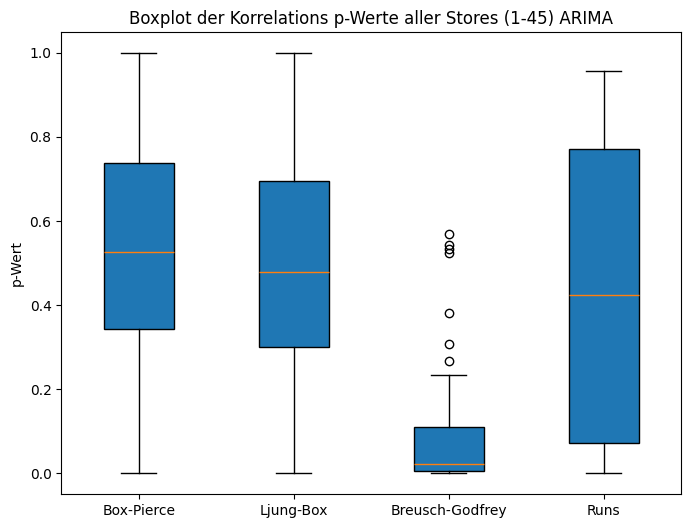

[0.31498312674601475, 0.7164030326180945, 0.5257260010851043, 0.3987413009540526, 0.20955908496817988, 0.5826926767106817, 0.16452868938073176, 0.39743323281559767, 0.34209504839011556, 0.9120847559093843, 0.36670239568520047, 0.30489763542331694, 0.4383109450360247, 0.5226827268573475, 0.19964422345385124, 0.873547457937354, 0.20229558661662378, 0.8265638129302331, 0.48525202643525, 0.605056637412191, 0.24636223968460946, 0.25329282833649425, 0.4389046727697592, 0.349346834188068, 0.9571068789077174, 0.5256684239739761, 0.8915717332848995, 0.15995896491471873, 0.08773833758236252, 0.9967117284485334, 0.9454983931073903, 0.642942573167905, 0.9466306114829787, 0.6954018052182441, 0.7380548689176685, 0.4600544811279226, 0.9989463517525489, 0.9744709015480648, 0.6686669017887542, 0.475583103869225, 0.6907676774172861, 0.0005116190374511328, 0.5835980458191268, 0.9886731441440101, 0.6501867607627384]


In [4]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(resid, lags=[10])
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(resid, lags=[10])
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_test(resid, lags=10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(resid)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, bg_pvalues, rt_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Boxplot der Korrelations p-Werte aller Stores (1-45) ARIMA")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Runs"])
plt.show()

print(bp_pvalues)

Durbin Watson

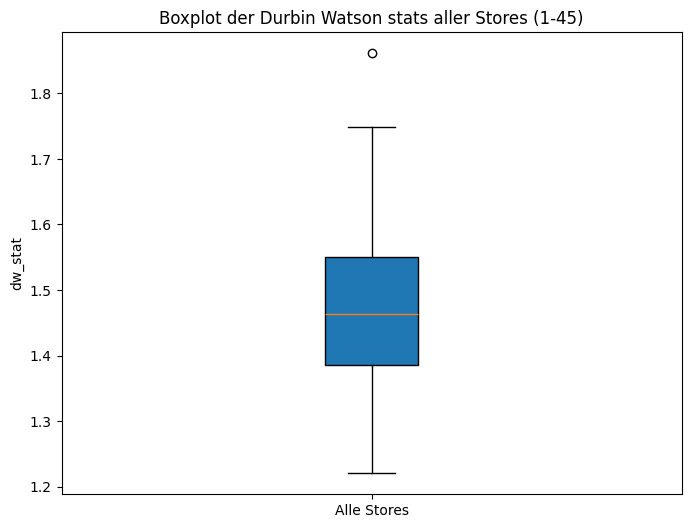

[1.3142960882591948, 1.4917964553065384, 1.4248760595761503, 1.3732648626988853, 1.461817390186436, 1.4819210970172987, 1.861250289952229, 1.3513451151455143, 1.4683461717628237, 1.573198052105678, 1.3191593732393234, 1.439095674487439, 1.4402460694426797, 1.4627066351469051, 1.5966140851203205, 1.577910929109131, 1.446508225740507, 1.6091519818564257, 1.3906026218328775, 1.453985860943729, 1.65943812161492, 1.5427148117579517, 1.7486666181563584, 1.3861164324865023, 1.7203551861156665, 1.5184969580600902, 1.5194472461829478, 1.4678538925037787, 1.59650666760261, 1.2491798950358544, 1.242477117787963, 1.4050910191657142, 1.2472506612033212, 1.3212051050546099, 1.5510287735837849, 1.220372510325533, 1.2553422082161247, 1.6171104599683352, 1.5289076304290246, 1.4145808192554776, 1.5487943414590197, 1.5237716267578507, 1.3139651596764954, 1.4114305841465917, 1.6950729162622933]


In [5]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True)
plt.title("Boxplot der Durbin Watson stats aller Stores (1-45)")
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()

print(dw_stats)

Mittelwert Tests

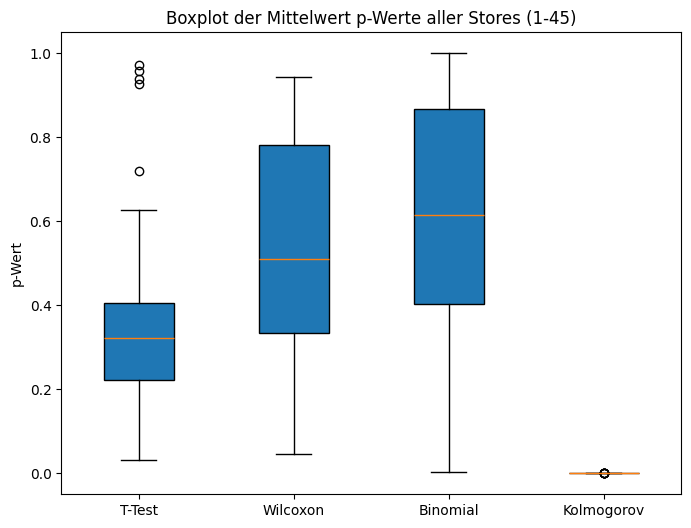

In [6]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Boxplot der Mittelwert p-Werte aller Stores (1-45)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov"])
plt.show()



Kreuzvalidierung